In [107]:
# !pip install pandas
# !pip install d2lzh

%matplotlib inline
import d2lzh as d2l 
from mxnet import autograd, gluon, init, nd 
from mxnet.gluon import data as gdata, loss as gloss, nn 
import numpy as np
import pandas as pd

heart = pd.read_csv("/Users/taijieshengwu/2024Research_SU-2/Data/heart.csv")
# print(heart.shape)


In [108]:

numeric_features = ["age","trtbps","chol","thalachh","oldpeak","caa"]

heart[numeric_features] = heart[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# print("heart.output",heart.output)
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
heart[numeric_features] = heart[numeric_features].fillna(0)


# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(heart, dummy_na=True)

n_train = heart.shape[0]
train_features = nd.array(all_features[:n_train].values)

train_labels = nd.array(all_features.output.values).reshape((-1, 1))


heart.output 0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: output, Length: 303, dtype: int64


In [109]:

loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    
    # 第一层
    net.add(nn.Dense(14, activation='relu'))  
    # 第二层 
    net.add(nn.Dense(4, activation='relu'))  
    # 输出层
    net.add(nn.Dense(1))  # 输出层, 1个神经元
    net.initialize()
    return net


import mxnet.ndarray as nd

def binary_cross_entropy(preds, labels):
    # 将预测值进行限制，避免出现 log(0)
    preds = nd.clip(preds, 1e-10, 1 - 1e-10)
    return -nd.mean(labels * nd.log(preds) + (1 - labels) * nd.log(1 - preds))

def log_bce(net, features, labels):
   
    preds = net(features)  
    
    # 计算损失
    bce_loss = binary_cross_entropy(preds, labels)
    return bce_loss.asscalar()  

def calculate_accuracy(net, features, labels):
    # 将预测值二值化，使用0.5作为阈值
    preds = net(features)
    predicted_labels = (preds > 0.5).astype(labels.dtype)
    # 计算准确率
    return nd.mean(predicted_labels == labels).asscalar()


In [110]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls, accura_ls= [], [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # print("train_iter",train_iter)
    # 这里使用了Adam优化算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    # print("trainer:",trainer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_bce(net, train_features, train_labels))
        accura_ls.append(calculate_accuracy(net, train_features, train_labels))
        # print("train_ls in loop:",train_ls)
        if test_labels is not None:
            test_ls.append(log_bce(net, test_features, test_labels))
        # print("train_ls1:",train_ls)
    return train_ls, test_ls,accura_ls


In [111]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [114]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum, accura_l_sum = 0, 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls,accura_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        accura_l_sum += accura_ls[-1]
        # print(valid_ls)
        # print("train_ls",train_ls)
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train loss%f, valid loss %f, accurate %f'
              % (i, train_ls[-1], valid_ls[-1], accura_ls[-1]))
    return train_l_sum / k, valid_l_sum / k, accura_l_sum / k


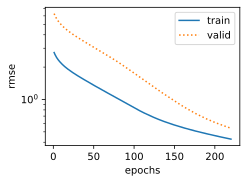

fold 0, train loss0.427362, valid loss 0.539597, accurate 0.816667
fold 1, train loss0.402422, valid loss 0.447391, accurate 0.833333
fold 2, train loss0.390140, valid loss 0.444457, accurate 0.841667
fold 3, train loss0.605538, valid loss 0.431873, accurate 0.679167
fold 4, train loss0.455561, valid loss 0.537518, accurate 0.808333
5-fold validation: avg train loss 0.456204, avg valid loss 0.480167, accuracy 0.795833


In [115]:

k, num_epochs, lr, weight_decay, batch_size = 5, 220, 0.00005, 0, 32
train_l, valid_l, accuracy_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train loss %f, avg valid loss %f, accuracy %f'
      % (k, train_l, valid_l, accuracy_l))
      

# MLP finding
感觉准确性不是很高，也有可能是因为网络设计或者手动调参数的问题，这个太容易梯度消失了，lr大了容易梯度消失，小了容易loss变大，试一下Random forest + GridSearchCV
